In [1]:
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from functools import cmp_to_key
import logging
import cv2

import  matplotlib.pyplot as plt

In [3]:
def imshow(img):
    """
    jupyter 内部可视化图像
    """
    plt.figure(dpi=150)
    plt.axis('off')
    # 3通道图像应从BGR转RGB再显示
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    # 灰度图应转为RGB
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [2]:
logger = logging.getLogger(__name__)
float_tolerance = 1e-7

In [4]:
def generateBaseImage(image, sigma, assumed_blur):
    """Generate base image from input image by upsampling by 2 in both directions and blurring
    """
    logger.debug('Generating base image...')
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  # the image blur is now sigma instead of assumed_blur

def computeNumberOfOctaves(image_shape):
    """Compute number of octaves in image pyramid as function of base image shape (OpenCV default)
    """
    return int(round(log(min(image_shape)) / log(2) - 1))

def generateGaussianKernels(sigma, num_intervals):
    """Generate list of gaussian kernels at which to blur the input image. Default values of sigma, intervals, and octaves follow section 3 of Lowe's paper.
    """
    logger.debug('Generating scales...')
    num_images_per_octave = num_intervals + 3
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = zeros(num_images_per_octave)  # scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

def generateGaussianImages(image, num_octaves, gaussian_kernels):
    """Generate scale-space pyramid of Gaussian images
    """
    logger.debug('Generating Gaussian images...')
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    return array(gaussian_images)

def generateDoGImages(gaussian_images):
    """Generate Difference-of-Gaussians image pyramid
    """
    logger.debug('Generating Difference-of-Gaussian images...')
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(subtract(second_image, first_image))  # ordinary subtraction will not work because the images are unsigned integers
        dog_images.append(dog_images_in_octave)
    return array(dog_images)

In [5]:
sigma=1.6
num_intervals=3
assumed_blur=0.5
image_border_width=5

In [6]:
# 读取图像
image = cv2.imread("images/Lena.png")
# 转灰度图
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 转化为灰度图

In [7]:
base_image = generateBaseImage(image, sigma, assumed_blur)
base_image = cv2.GaussianBlur(image, ksize=(0,0), sigmaX=1.6, sigmaY=1.6)

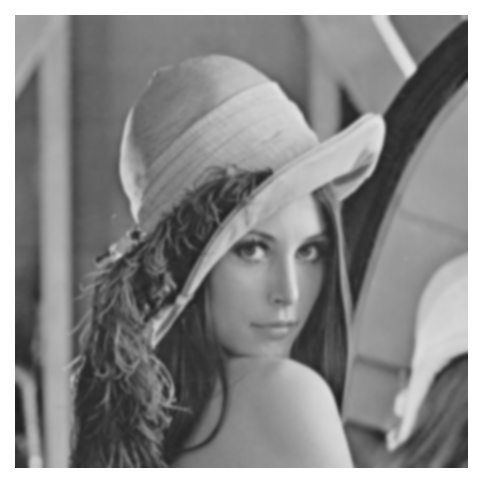

In [8]:
imshow(base_image)

In [9]:
num_octaves = computeNumberOfOctaves(base_image.shape)
print(num_octaves)

8


In [10]:
base_image.shape

(512, 512)

In [11]:
gaussian_kernels = generateGaussianKernels(2*sigma, num_intervals)

In [12]:
gaussian_kernels

array([3.2       , 2.452547  , 3.09001559, 3.89317568, 4.90509399,
       6.18003117])

In [13]:
gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)

<ipython-input-4-7ce81bdfc79d>:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(gaussian_images)


In [14]:
gaussian_images[7][0].shape

(4, 4)

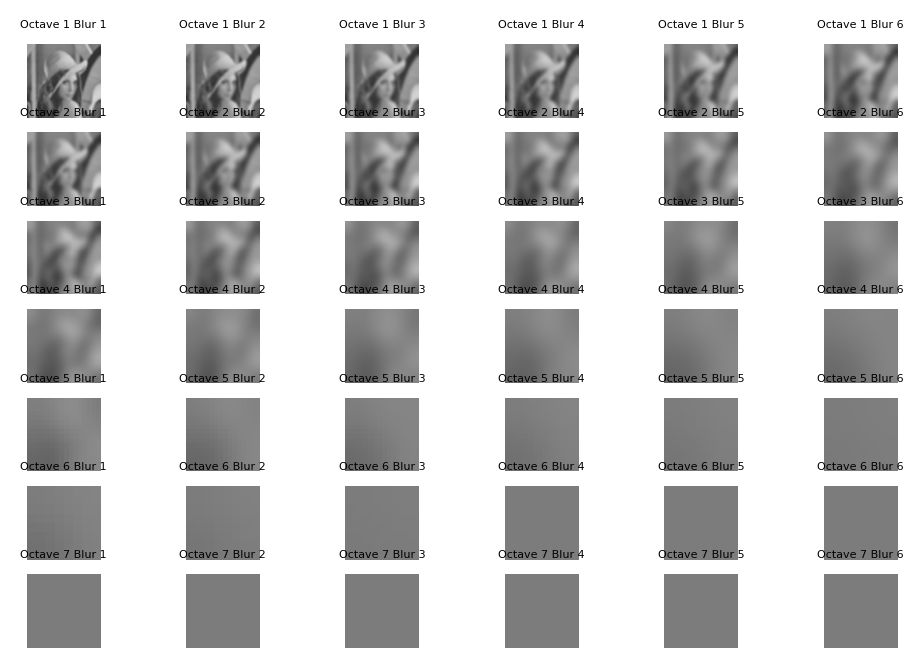

In [15]:
## 可视化模糊图
i = 1
j = 1
plt.figure(dpi=200)
for Blur in gaussian_images[1:]:
    for blur_image in Blur:
        plt.subplot(len(gaussian_images[1:]),len(Blur),i)
        plt.imshow(cv2.cvtColor(blur_image, cv2.COLOR_GRAY2RGB))
        plt.title("Octave {} Blur {}".format(j, (i-1)%len(Blur)+1), fontsize=4)
        plt.axis('off')
        # plt.yticks(fontproperties = 'Times New Roman', size = 4)
        # plt.xticks(fontproperties = 'Times New Roman', size = 4)
        i += 1
    j += 1
plt.show()

In [16]:
dog_images = generateDoGImages(gaussian_images)

<ipython-input-4-7ce81bdfc79d>:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(dog_images)


In [17]:
dog_images[0][0].min()

0

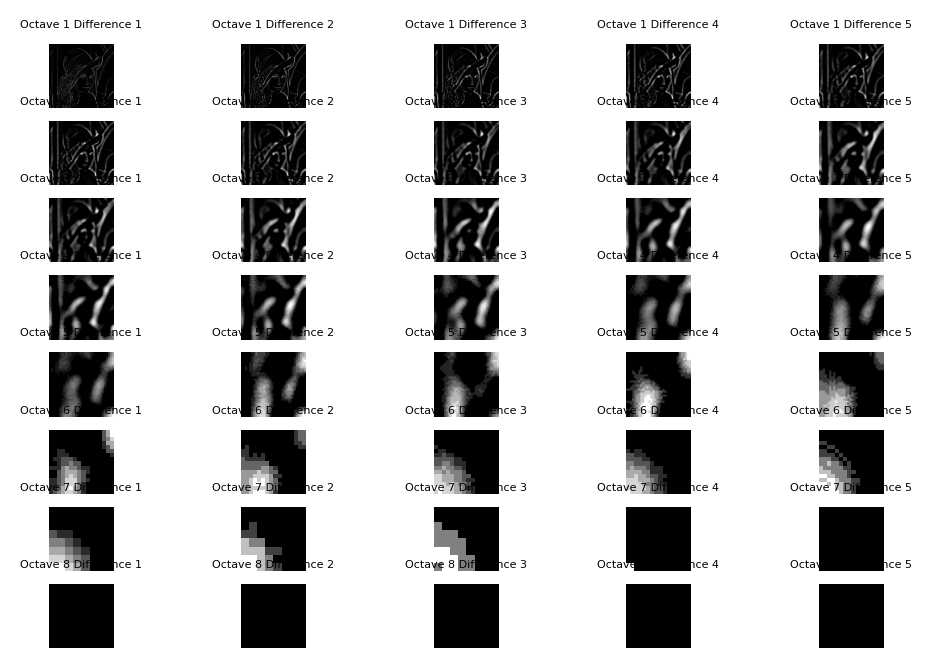

In [18]:
## 可视化
i = 1
j = 1
plt.figure(dpi=200)
for difference in dog_images:
    for difference_image in difference:
        plt.subplot(len(dog_images),len(difference),i)
        plt.imshow(difference_image, cmap=plt.get_cmap('gray'))
        plt.title("Octave {} Difference {}".format(j, (i-1)%len(difference)+1), fontsize=4)
        plt.axis('off')
        # plt.yticks(fontproperties = 'Times New Roman', size = 4)
        # plt.xticks(fontproperties = 'Times New Roman', size = 4)
        i += 1
    j += 1
plt.show()

In [19]:
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    """Find pixel positions of all scale-space extrema in the image pyramid
    """
    logger.debug('Finding scale-space extrema...')
    # 对比度阈值
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  # from OpenCV implementation
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    # 逐步搜索，寻找极值点，i，j对应着扫描的中心点
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        # 二次拟合
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    return keypoints

def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise
    """
    center_pixel_value = second_subimage[1, 1]
    # 必须大于对比度
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    """Iteratively refine pixel positions of scale-space extrema via quadratic fit around each extremum's neighbors
        i,j为对应扫描的中心点
        image_index为中间层那个图像的索引（小sigma和大sigma之间的）
        octave_index为第几层金字塔层
        num_intervals：scale 空间，为3
        dog_images_in_octave：那一层的全部差分图
        sigma：分数
        contrast_threshold：对比度
        image_border_width：边界不扫描
    """
    logger.debug('Localizing scale-space extrema...')
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    # 循环，定位再循环
    for attempt_index in range(num_attempts_until_convergence):
        # need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's thresholds
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube) #梯度，向量
        hessian = computeHessianAtCenterPixel(pixel_cube)   #二阶导，矩阵
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]  
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        # make sure the new pixel_cube will lie entirely within the image
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

def computeGradientAtCenterPixel(pixel_array):
    """Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f'(x) is (f(x + h) - f(x - h)) / (2 * h)
    # Here h = 1, so the formula simplifies to f'(x) = (f(x + 1) - f(x - 1)) / 2
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
    """Approximate Hessian at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f''(x) is (f(x + h) - 2 * f(x) + f(x - h)) / (h ^ 2)
    # Here h = 1, so the formula simplifies to f''(x) = f(x + 1) - 2 * f(x) + f(x - 1)
    # With step size h, the central difference formula of order O(h^2) for (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
    # Here h = 1, so the formula simplifies to (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint
    """
    logger.debug('Computing keypoint orientations...')
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

In [20]:
keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)

<ipython-input-19-5c7de6cdf3e6>:150: RuntimeWarning: overflow encountered in ubyte_scalars
  dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
<ipython-input-19-5c7de6cdf3e6>:152: RuntimeWarning: overflow encountered in ubyte_scalars
  gradient_magnitude = sqrt(dx * dx + dy * dy)
<ipython-input-19-5c7de6cdf3e6>:151: RuntimeWarning: overflow encountered in ubyte_scalars
  dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]


In [25]:
len(keypoints)

10469